In [63]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.tools import diff
import pmdarima as pm
from scipy.stats import boxcox
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.stattools import acf as acf_values, pacf as pacf_values
np.random.seed(0)  

# Data Understanding

In [33]:
df = pd.read_csv("SPX.csv")

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23323 entries, 0 to 23322
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       23323 non-null  object 
 1   Open       23323 non-null  float64
 2   High       23323 non-null  float64
 3   Low        23323 non-null  float64
 4   Close      23323 non-null  float64
 5   Adj Close  23323 non-null  float64
 6   Volume     23323 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ MB


In [35]:
df = df[["Date", "Close"]]
df["Date"] = pd.to_datetime(df["Date"])

In [36]:
df.info(), df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23323 entries, 0 to 23322
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    23323 non-null  datetime64[ns]
 1   Close   23323 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 364.6 KB


(None,
         Date      Close
 0 1927-12-30  17.660000
 1 1928-01-03  17.760000
 2 1928-01-04  17.719999
 3 1928-01-05  17.549999
 4 1928-01-06  17.660000
 5 1928-01-09  17.500000
 6 1928-01-10  17.370001
 7 1928-01-11  17.350000
 8 1928-01-12  17.469999
 9 1928-01-13  17.580000)

In [37]:
px.line(df, "Date", "Close")

In [38]:
## Locate where date in the earliest 2016
df[df["Date"]=="2016-01-04"]


,Date,Close
22103,2016-01-04,2012.660034


In [39]:
## Truncate to that date
df = df[22103:].reset_index(drop=True)

In [40]:
px.line(df, "Date", "Close")

In [41]:
# Split data for 3 months of outsample
df[df["Date"]=="2020-07-01"]

,Date,Close
1131,2020-07-01,3115.860107


In [42]:
df_insample = df[:1131]
df_outsample = df[1131:]

In [43]:
df_insample.info(),
df_outsample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1131 non-null   datetime64[ns]
 1   Close   1131 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 1131 to 1219
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    89 non-null     datetime64[ns]
 1   Close   89 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 KB


In [44]:
df_insample['Type'] = 'In-sample'
df_outsample['Type'] = 'Out-sample'
df_combined = pd.concat([df_insample, df_outsample])


px.line(df_combined, x="Date", y="Close", color='Type',
        title="In-sample vs Out-sample Close Prices")


C:\Users\Asem\AppData\Local\Temp\ipykernel_14740\3935955253.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Asem\AppData\Local\Temp\ipykernel_14740\3935955253.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# ARIMA

## Determine Stationarity and p,d,q orders

### In Variance Stationarity

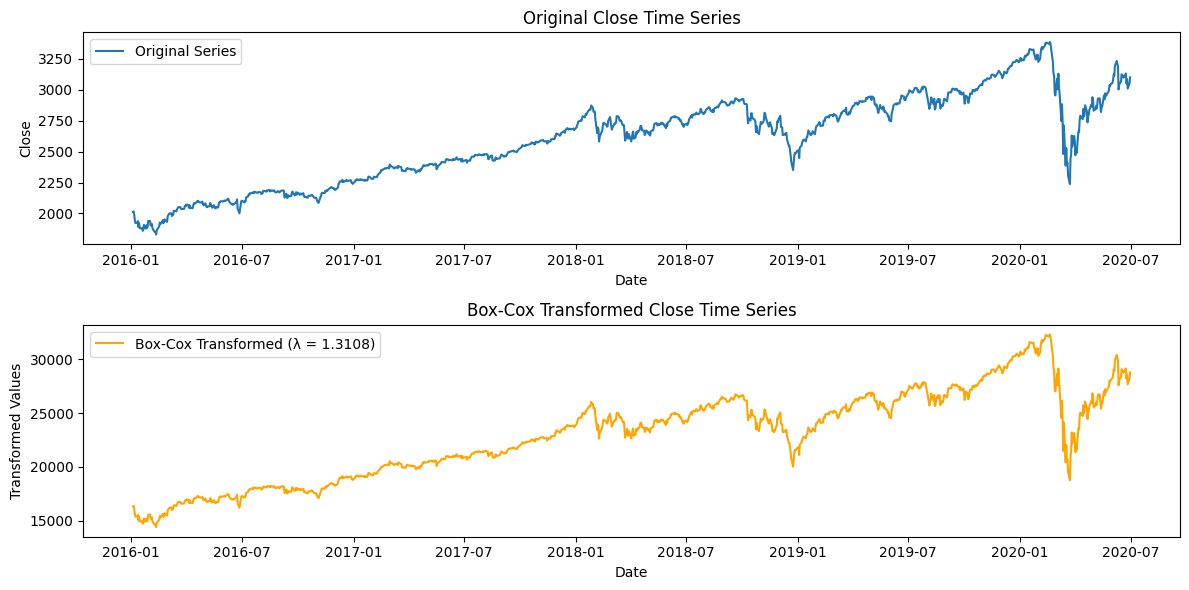

In [45]:
def box_cox_transformation(df, column):
    """
    Perform Box-Cox transformation and visualize the results.
    
    Parameters:
    df (pd.DataFrame): Input dataframe containing the time series data.
    column (str): The column name of the time series data to be transformed.
    
    Returns:
    transformed_series (pd.Series): The Box-Cox transformed time series.
    lambda_bc (float): The lambda value used in the Box-Cox transformation.
    """
    
    if (df[column] <= 0).any():
        df[column] += abs(df[column].min()) + 1

    transformed_series, lambda_bc = boxcox(df[column])

    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df[column], label='Original Series')
    plt.title(f"Original {column} Time Series")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(df['Date'], transformed_series, label=f'Box-Cox Transformed (λ = {lambda_bc:.4f})', color='orange')
    plt.title(f"Box-Cox Transformed {column} Time Series")
    plt.xlabel("Date")
    plt.ylabel("Transformed Values")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return transformed_series, lambda_bc

transformed_series_insample, lambda_bc = box_cox_transformation(df_insample, column='Close')

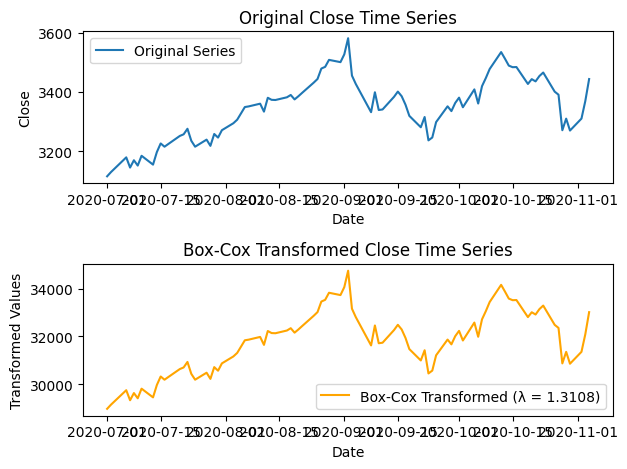

In [46]:
## Dont forget to transform the outsample as well

def box_cox(df, column, lambda_bc):
    transformed_series = stats.boxcox(df[column], lmbda = lambda_bc)

    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df[column], label='Original Series')
    plt.title(f"Original {column} Time Series")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(df['Date'], transformed_series, label=f'Box-Cox Transformed (λ = {lambda_bc:.4f})', color='orange')
    plt.title(f"Box-Cox Transformed {column} Time Series")
    plt.xlabel("Date")
    plt.ylabel("Transformed Values")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return transformed_series

transformed_series_outsample = box_cox(df_outsample, "Close", lambda_bc)


In [47]:
## Put transformed data in dataframe
df_insample["Close"] = transformed_series_insample
df_outsample["Close"] = transformed_series_outsample

C:\Users\Asem\AppData\Local\Temp\ipykernel_14740\2842533825.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Asem\AppData\Local\Temp\ipykernel_14740\2842533825.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### To Check in Mean Stationarity

<Figure size 1000x500 with 0 Axes>

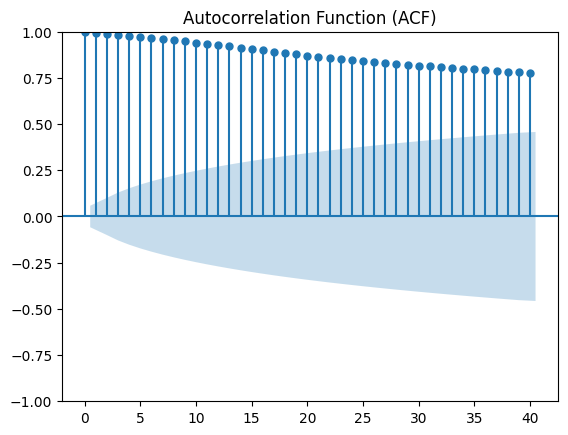

<Figure size 1000x500 with 0 Axes>

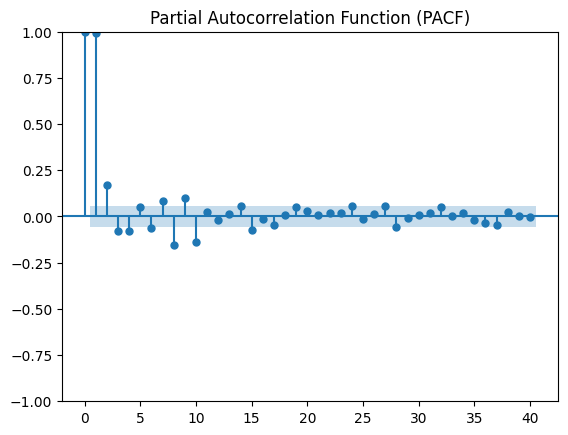

In [48]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure(figsize=(10, 5))
plot_acf(df_insample['Close'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plt.figure(figsize=(10, 5))
plot_pacf(df_insample['Close'], lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## As shown, data is not in stationary in mean

In [49]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")
    
    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid(); 

ADF Statistic: -1.95
p-value: 0.309
Critical Values: ['1%: -3.44', '5%: -2.86', '10%: -2.57']



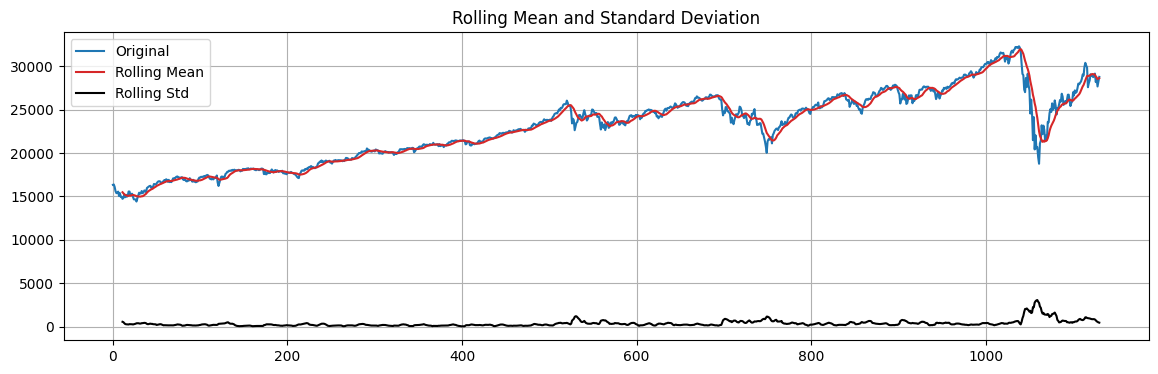

In [50]:
adftest(df_insample["Close"])
## ADF test shows that it does not follow unit root i.e. not stationary in mean

In [51]:
def check_stationarity(df, column, diff_order=1):
    """
    Parameters:
    1. df (pd.DataFrame): The input dataframe containing the time series data.
    2. column (str): The column name of the time series data to be tested.
    3. diff_order (int): The order of differencing to apply.
    """
    
    diff_series = df[column].diff(periods=diff_order).dropna()
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df[column], label=f'Original {column}')
    plt.plot(df['Date'][diff_order:], diff_series, label=f'Differenced (Order {diff_order}) {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.title(f"Original vs Differenced (Order {diff_order}) Time Series")
    plt.show()

    adf_result = adfuller(diff_series)
    
    print("ADF Test Results:")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value}")
    
    if adf_result[1] < 0.05:
        print("The series is likely stationary (Reject H0)")
        return diff_series
    else:
        print("The series is likely non-stationary (Fail to reject H0)")

    


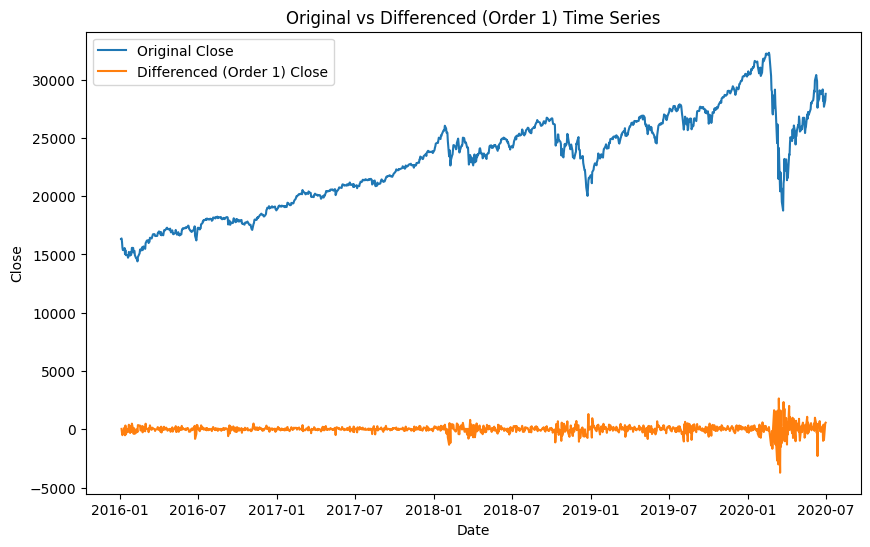

ADF Test Results:
ADF Statistic: -9.696231617163694
p-value: 1.1024848416950867e-16
Critical Values:
   1%: -3.436196866494929
   5%: -2.864121720649023
   10%: -2.568144581443706
The series is likely stationary (Reject H0)


In [52]:
temp = check_stationarity(df_insample, "Close", diff_order=1)

In [53]:
len(temp), df_insample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1131 non-null   datetime64[ns]
 1   Close   1131 non-null   float64       
 2   Type    1131 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 26.6+ KB


(1130, None)

### p,d,q Orders Identification

<Figure size 1000x500 with 0 Axes>

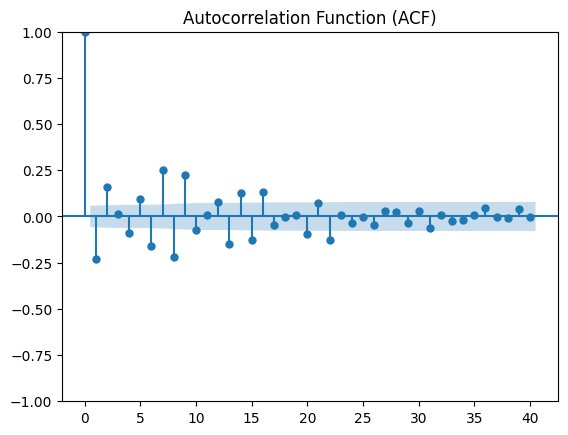

<Figure size 1000x500 with 0 Axes>

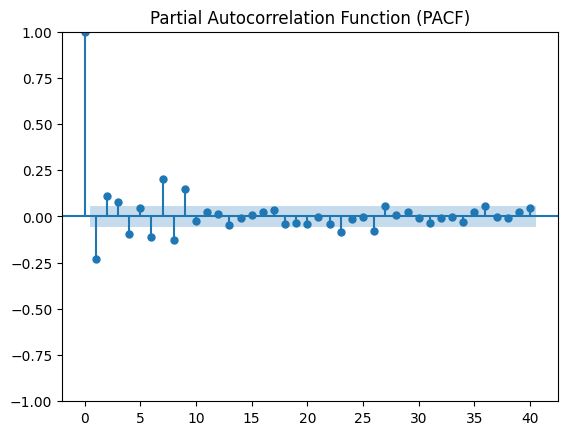

In [54]:
# ACF plot
plt.figure(figsize=(10, 5))
plot_acf(temp, lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plt.figure(figsize=(10, 5))
plot_pacf(temp, lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## As shown, data is probably in a stationary mode

Based on PACF and ACF, possible params includes:
$$p: 1, 2, 3, 4, 6, 7, 8, 9$$
$$q: 1, 2, 4, 6, 7, 8, 9$$
with $d=1$, the possible combination for ARIMA models are:
1. [1, 1, 1]
2. [1, 1, 2]
3. [1, 1, 4]
4. [1, 1, 6]
5. [1, 1, 7]
6. [1, 1, 8]
7. [1, 1, 9]
8. [2, 1, 1]
9. [2, 1, 2]
10. [2, 1, 4]
11. [2, 1, 6]
12. [2, 1, 7]
13. [2, 1, 8]
14. [2, 1, 9]
15. [3, 1, 1]
16. [3, 1, 2]
17. [3, 1, 4]
18. [3, 1, 6]
19. [3, 1, 7]
20. [3, 1, 8]
21. [3, 1, 9]
22. [4, 1, 1]
23. [4, 1, 2]
24. [4, 1, 4]
25. [4, 1, 6]
26. [4, 1, 7]
27. [4, 1, 8]
28. [4, 1, 9]
29. [6, 1, 1]
30. [6, 1, 2]
31. [6, 1, 4]
32. [6, 1, 6]
33. [6, 1, 7]
34. [6, 1, 8]
35. [6, 1, 9]
36. [7, 1, 1]
37. [7, 1, 2]
38. [7, 1, 4]
39. [7, 1, 6]
40. [7, 1, 7]
41. [7, 1, 8]
42. [7, 1, 9]
43. [8, 1, 1]
44. [8, 1, 2]
45. [8, 1, 4]
46. [8, 1, 6]
47. [8, 1, 7]
48. [8, 1, 8]
49. [8, 1, 9]
50. [9, 1, 1]
51. [9, 1, 2]
52. [9, 1, 4]
53. [9, 1, 6]
54. [9, 1, 7]
55. [9, 1, 8]
56. [9, 1, 9]

In [56]:
pdq_combinations = [
    (1, 1, 1),
(1, 1, 2),
(1, 1, 4),
(1, 1, 6),
(1, 1, 7),
(1, 1, 8),
(1, 1, 9),
(2, 1, 1),
(2, 1, 2),
(2, 1, 4),
(2, 1, 6),
(2, 1, 7),
(2, 1, 8),
(2, 1, 9),
(3, 1, 1),
(3, 1, 2),
(3, 1, 4),
(3, 1, 6),
(3, 1, 7),
(3, 1, 8),
(3, 1, 9),
(4, 1, 1),
(4, 1, 2),
(4, 1, 4),
(4, 1, 6),
(4, 1, 7),
(4, 1, 8),
(4, 1, 9),
(6, 1, 1),
(6, 1, 2),
(6, 1, 4),
(6, 1, 6),
(6, 1, 7),
(6, 1, 8),
(6, 1, 9),
(7, 1, 1),
(7, 1, 2),
(7, 1, 4),
(7, 1, 6),
(7, 1, 7),
(7, 1, 8),
(7, 1, 9),
(8, 1, 1),
(8, 1, 2),
(8, 1, 4),
(8, 1, 6),
(8, 1, 7),
(8, 1, 8),
(8, 1, 9),
(9, 1, 1),
(9, 1, 2),
(9, 1, 4),
(9, 1, 6),
(9, 1, 7),
(9, 1, 8),
(9, 1, 9)
]

### AutoARIMA Modelling

In [57]:
model = pm.auto_arima(
    y=df_insample["Close"], 
    start_p=0,
    start_q=0,
    max_p=9,
    max_d=1,
    max_q=9,
    seasonal=False,           
    m=1,                      
    stepwise=False,           
    suppress_warnings=True,
    information_criterion='aic',  
    n_jobs=-1,                
    trace=True,               
    order=None,              
    scoring='mse',            
    error_action='ignore',    
    with_intercept="auto",    
    max_order=None,           
    grid_search_kwargs={
        "orders": pdq_combinations  
    }
)



Best model:  ARIMA(4,1,8)(0,0,0)[0] intercept
Total fit time: 208.512 seconds


Best model:  ARIMA(4,1,8)(0,0,0)[0] intercept

Total fit time: 208.512 seconds

In [58]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1131
Model:               SARIMAX(4, 1, 8)   Log Likelihood               -8216.069
Date:                Sat, 21 Sep 2024   AIC                          16460.137
Time:                        19:42:09   BIC                          16530.557
Sample:                             0   HQIC                         16486.742
                               - 1131                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.3394     16.324      0.817      0.414     -18.655      45.334
ar.L1         -0.0571      0.035     -1.645      0.100      -0.125       0.011
ar.L2          0.7872      0.031     25.731      0.000       0.727       0.847
ar.L3         -0.2231      0.030     -7.379      0.000      -0.282      -0.164
ar.L4         -0.7953      0.029    -27.864      0.000      -0.851      -0.739
ma.L1         -0.0660      0.037     -1.783      0.075      -0.139       0.007
ma.L2         -0.7070      0.034    -20.815      0.000      -0.774      -0.640
ma.L3          0.3744      0.034     10.953      0.000       0.307       0.441
ma.L4          0.6142      0.032     19.233      0.000       0.552       0.677
ma.L5         -0.0747      0.021     -3.565      0.000      -0.116      -0.034
ma.L6          0.0656      0.020      3.300      0.001       0.027       0.105
ma.L7          0.1706      0.019      9.129      0.000       0.134       0.207
ma.L8         -0.1167      0.025     -4.702      0.000      -0.165      -0.068
sigma2      1.226e+05   2203.351     55.643      0.000    1.18e+05    1.27e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):              9460.25
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               8.10   Skew:                            -1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Try Forecasting

In [59]:
forecast_steps = 89
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)

In [60]:
forecast

1131    28739.716640
1132    28962.861563
1133    28712.903298
1134    28809.273453
1135    28466.772915
            ...     
1215    29542.698455
1216    29547.981721
1217    29561.031834
1218    29580.675785
1219    29603.195332
Length: 89, dtype: float64

In [61]:
df_outsample.tail()

,Date,Close,Type
1215,2020-10-29,31352.950144,Out-sample
1216,2020-10-30,30855.384875,Out-sample
1217,2020-11-02,31354.562792,Out-sample
1218,2020-11-03,32088.141722,Out-sample
1219,2020-11-04,33018.652487,Out-sample


In [64]:
forecast_index = pd.date_range(start=df_insample['Date'].iloc[-1], periods=forecast_steps+1, freq='D')[1:]
df_forecast = pd.DataFrame({'Date': forecast_index, 'Forecast': forecast})

df_compare = pd.merge(df_outsample.head(forecast_steps), df_forecast, on='Date')

rmse = mean_squared_error(df_compare['Close'], df_compare['Forecast'], squared=False)
print(f"RMSE: {rmse}")

fig = px.line(df_compare, x='Date', y=['Close', 'Forecast'], title="Actual vs Forecasted Close Price")
fig.show()

RMSE: 2600.655083870793


c:\Users\Asem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



# SARIMA

# GARCH

# Prophet

# Best of All